# Deadlines aus Simulation (FIFO)

In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

from src.utils.production_process import initialize as init

# Extern
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
pd.set_option('display.min_rows', 21)
pd.set_option('display.max_rows', 25)

In [2]:
import src.utils.figurator as fig_gen

In [3]:
basic_data_path = get_path("data", "basic")
day_count = 360
# day_count = 600

df_jobs_times = pd.read_csv(basic_data_path / f"jobs_times_{day_count}_raw.csv")
df_jobs_times

,Job,Production_Plan_ID,Arrival,Ready Time,End,Processing Time
0,0,0,51,1440,3050.0,395
1,1,1,136,1440,2736.0,510
2,2,2,158,1440,2258.0,568
3,3,3,236,1440,2926.0,655
4,4,4,404,1440,3007.0,393
5,5,5,485,1440,2731.0,496
6,6,6,501,1440,2646.0,416
7,7,7,528,1440,3085.0,539
8,8,8,550,1440,2985.0,597
9,9,9,559,1440,2970.0,540


## II) Log-Normalverteilung

In [4]:
def add_groupwise_lognormal_deadlines_by_group_mean(
    df: pd.DataFrame,
    sigma: float = 0.2,
    seed: int = 42
) -> pd.DataFrame:
    """
    Für jede Gruppe in 'Production_Plan_ID' wird eine Lognormalverteilung
    mit Parameter mu so berechnet, dass der Mittelwert der Deadlines genau
    dem Mittelwert der 'End'-Werte der Gruppe entspricht.

    Jeder Deadline-Wert in der Gruppe wird einzeln zufällig aus dieser Verteilung gezogen.

    Parameters
    ----------
    df : pd.DataFrame
        Muss Spalten 'Production_Plan_ID' und 'End' enthalten.
    sigma : float, optional
        Standardabweichung der Lognormalverteilung (Default 0.2).
    seed : int, optional
        Zufalls-Seed (Default 42).

    Returns
    -------
    pd.DataFrame
        Kopie von df mit neuer Spalte 'Deadline' (float, 1 Dezimalstelle).
    """
    np.random.seed(seed)
    df_out = df.copy()
    df_out['Deadline'] = np.nan

    for plan_id, grp in df_out.groupby('Production_Plan_ID'):
        group_mean_end = grp['End'].mean()
        mu = np.log(group_mean_end) - 0.5 * sigma**2

        # Für jede Zeile in Gruppe eine Deadline aus LogNormal(mu, sigma)
        deadlines = np.random.lognormal(mean=mu, sigma=sigma, size=len(grp))
        df_out.loc[grp.index, 'Deadline'] = np.round(deadlines, 1) 

    return df_out

In [5]:
df_times = add_groupwise_lognormal_deadlines_by_group_mean(df_jobs_times, sigma=0.4)
df_times

,Job,Production_Plan_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,0,0,51,1440,3050.0,395,298584.5
1,1,1,136,1440,2736.0,510,476191.1
2,2,2,158,1440,2258.0,568,232752.4
3,3,3,236,1440,2926.0,655,203923.2
4,4,4,404,1440,3007.0,393,396273.6
5,5,5,485,1440,2731.0,496,272136.1
6,6,6,501,1440,2646.0,416,155214.4
7,7,7,528,1440,3085.0,539,235763.6
8,8,8,550,1440,2985.0,597,378474.0
9,9,9,559,1440,2970.0,540,285216.7


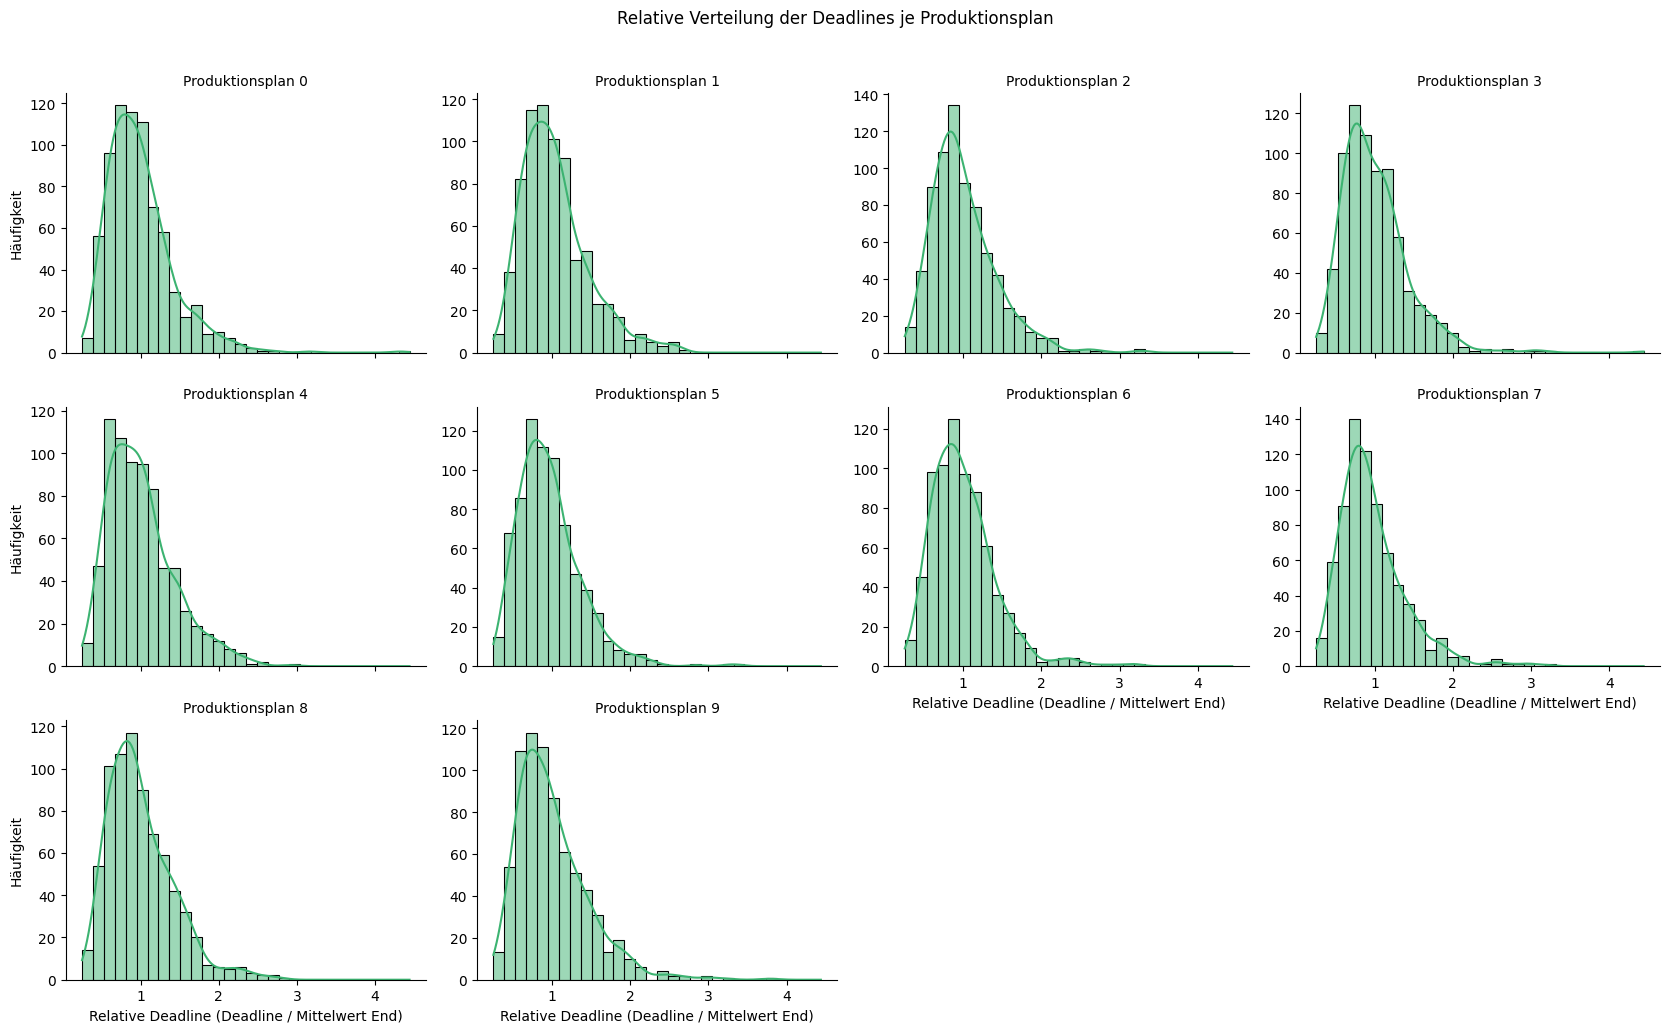

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_groupwise_relative_deadline_distribution(df: pd.DataFrame, bins: int = 30):
    """
    Plottet pro Gruppe die Verteilung der Deadlines relativ zum Gruppenmittelwert (Deadline / mean(End)).

    Parameters
    ----------
    df : pd.DataFrame
        Muss Spalten 'Production_Plan_ID', 'End' und 'Deadline' enthalten.
    bins : int, optional
        Anzahl der Histogrammbins (Default 30).
    """
    if not {'Production_Plan_ID', 'End', 'Deadline'}.issubset(df.columns):
        raise ValueError("DataFrame benötigt Spalten 'Production_Plan_ID', 'End' und 'Deadline'.")

    df_plot = df.copy()

    # Berechne pro Gruppe den Mittelwert von End
    group_means = df_plot.groupby('Production_Plan_ID')['End'].transform('mean')
    
    # Relative Deadline als Verhältnis Deadline / Mittelwert(End)
    df_plot['Relative_Deadline'] = df_plot['Deadline'] / group_means

    g = sns.displot(
        data=df_plot,
        x='Relative_Deadline',
        col='Production_Plan_ID',
        col_wrap=4,
        kde=True,
        bins=bins,
        facet_kws={'sharex': True, 'sharey': False},
        height=3.5,
        aspect=1.2,
        color='mediumseagreen'
    )
    g.set_titles(col_template="Produktionsplan {col_name}")
    g.set_axis_labels("Relative Deadline (Deadline / Mittelwert End)", "Häufigkeit")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle("Relative Verteilung der Deadlines je Produktionsplan")
    plt.show()

plot_groupwise_relative_deadline_distribution(df_times)

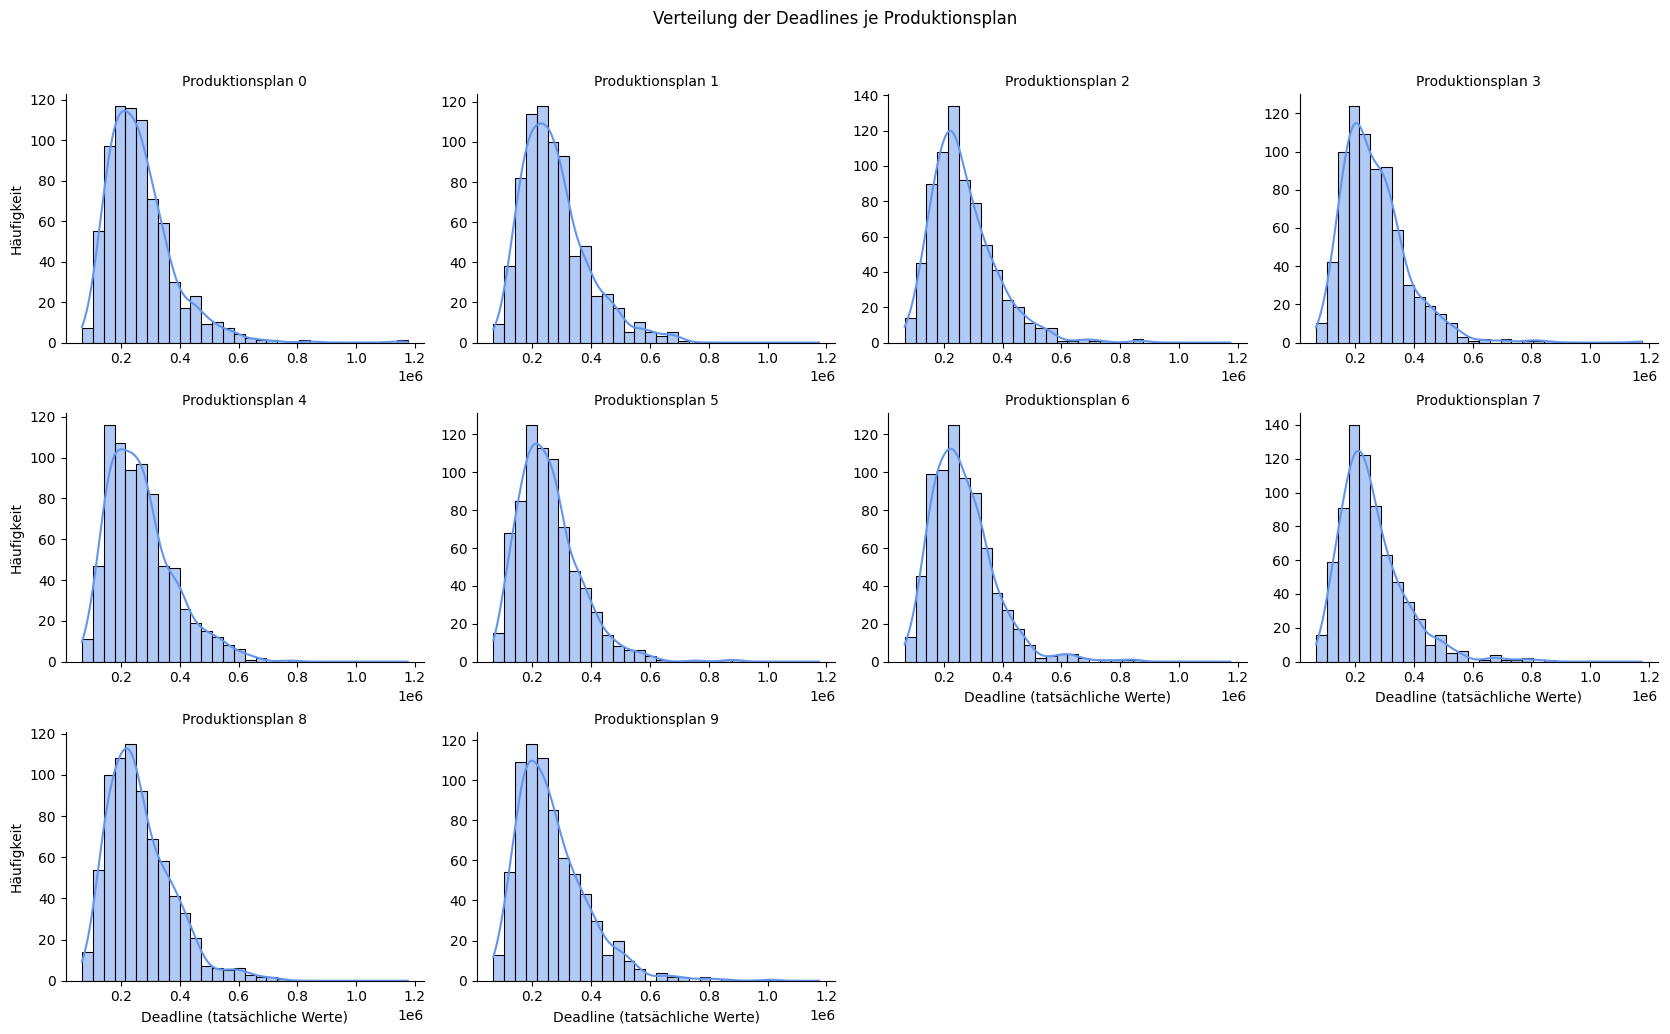

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_groupwise_absolute_deadline_distribution(df: pd.DataFrame, bins: int = 30):
    """
    Plottet pro Gruppe die Verteilung der absoluten Deadline-Werte.

    Parameters
    ----------
    df : pd.DataFrame
        Muss Spalten 'Production_Plan_ID' und 'Deadline' enthalten.
    bins : int, optional
        Anzahl der Histogrammbins (Default 30).
    """
    if not {'Production_Plan_ID', 'Deadline'}.issubset(df.columns):
        raise ValueError("DataFrame benötigt Spalten 'Production_Plan_ID' und 'Deadline'.")

    g = sns.displot(
        data=df,
        x='Deadline',
        col='Production_Plan_ID',
        col_wrap=4,
        kde=True,
        bins=bins,
        facet_kws={'sharex': False, 'sharey': False},
        height=3.5,
        aspect=1.2,
        color='cornflowerblue'
    )
    g.set_titles(col_template="Produktionsplan {col_name}")
    g.set_axis_labels("Deadline (tatsächliche Werte)", "Häufigkeit")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle("Verteilung der Deadlines je Produktionsplan")
    plt.show()

plot_groupwise_absolute_deadline_distribution(df_times)